### Starbucks Capstone Challenge
# Data Exploration

This notebook aims to load files and present some data visualization in order to understand the distribution and characteristics of the data, and possibly identify inconsistencies.  

Data exploration is one of the most important parts of the machine learning workflow because it allows you to notice any initial patterns in data distribution and features that may inform how to proceed with modeling and clustering the data.  

Data exploration uses visual exploration to understand what is in a dataset and the characteristics of the data. These characteristics can include size or amount of data, completeness and correctness of the data, and possible relationships amongst data elements.

In [1]:
## Import all the necessary libraries
import base64
import os
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display_html
from matplotlib.figure import Figure
from sklearn.preprocessing import robust_scale, quantile_transform, scale

In [2]:
## Global definitions

data_dir = 'data'

pd.set_option('display.precision', 2)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

portfolio_data_path = os.path.join(data_dir, 'portfolio.json')
profile_data_path = os.path.join(data_dir, 'profile.json')
transcript_data_path = os.path.join(data_dir, 'transcript.json')

In [3]:
## global functions

def load_dataframe(data_path):
    """Create a dataframe from a json file"""
    return pd.read_json(data_path, orient='records', lines=True)


def convert_fig_to_html(figure):
    """
    Convert a given matplotlib figure to HTML code
    
    Attributes:
    figure (matplotlib.figure.Figure): Generated without using pyplot.
    
    Return:
    return: img-html tag containing the figure data
    """
    # Save figure to a temporary buffer
    buf = BytesIO()
    figure.savefig(buf, format="png")
    # Embed the result in the html output
    data = base64.b64encode(buf.getbuffer()).decode("ascii")
    return f'<img src="data:image/png;base64,{data}" ' \
            'style="display:inline;top:0%"/>'

# Portfolio data set
Data set containing information about the offers which can be sent to customers.

## Overview

In [4]:
portfolio_df = load_dataframe(portfolio_data_path)
display(portfolio_df)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


There are three types of offers that can be sent: buy-one-get-one
(BOGO), discount, and informational:
* In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount.  
* In a discount, a user gains a reward equal to a fraction of the amount spent.  
* In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend.

Offers can be delivered via multiple channels:
* email
* social media
* on the web
* via the Starbucks’s app.

Every offer has a validity period (*duration*) before the offer expires.  
We see that informational offers have a validity period even though these ads are merely providing information about a product. Here, the duration is the assumed period in which the customer is feeling the influence of the offer after receiving the advertisement.

## Analysis

In [5]:
print('Missing data: {}\n'.format(portfolio_df.isna().any().any()))

print('Dataset description:')
display(pd.DataFrame(portfolio_df.describe()))

Missing data: False

Dataset description:


,reward,difficulty,duration
count,10.00,10.00,10.00
mean,4.20,7.70,6.50
std,3.58,5.83,2.32
min,0.00,0.00,3.00
25%,2.00,5.00,5.00
50%,4.00,8.50,7.00
75%,5.00,10.00,7.00
max,10.00,20.00,10.00


In this portfolio, any offer is sent by email, so this is an informative feature and might be filtered out when feeding the neural networks.  
Apart from that, no issue is noticeable in this dataset.

## Scale values
Features *reward*, *difficulty*, and *duration* present values in different ranges. It is a good practice to scale then to the same range than other features.

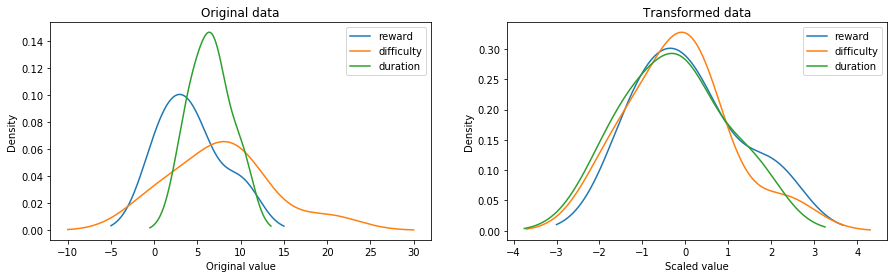

In [6]:
fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2)

rdd_df = portfolio_df[['reward','difficulty','duration']]
rdd_df.plot.density(ax=axs[0])
axs[0].set_title('Original data')
axs[0].set_xlabel('Original value')

data_transformed = robust_scale(rdd_df)
rdd_df = pd.DataFrame(data_transformed, columns=rdd_df.columns, index=rdd_df.index)

rdd_df.plot.density(ax=axs[1])
axs[1].set_title('Transformed data')
axs[1].set_xlabel('Scaled value')

plt.show()

# Profile data set
Dataset containing demographic data for each one of the reward program users.

## Overview

In [7]:
profile_df = load_dataframe(profile_data_path)
display(profile_df.head())

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


## Exploration

### Analyzing the missing values
At a glance, it is possible to notice empty values in columns **income** and **gender**, as well as missing value encoded as 118 in the column **age**.  
Also, aparently, those values are present in the same rows. It would be productive to verify if they always accur together.

In [8]:
display(pd.DataFrame(profile_df.count()).T \
        .style.set_caption('Counting not null features'))

display(profile_df.describe().T \
        .style.set_caption('Dataframe description'))

display(pd.DataFrame(profile_df.gender.value_counts()).T \
        .style.set_caption('Gender by user'))

print('\nInvestigating whether all missing values are in the same rows.')
gender_isna = profile_df.gender.isna()
income_isna = profile_df.income.isna()
age_missing = profile_df.age == 118

print('Gender:\tnumber of NA: \t', gender_isna.sum())
print('Income:\tnumber of NA: \t', income_isna.sum())
print('Age:\tmissing values:\t', age_missing.sum())

print('\nAre gender and income missing in the same rows?\t{}' \
      .format(gender_isna.isin(income_isna).all()))
print('Are gender and age missing in the same rows?\t{}' \
      .format(gender_isna.isin(age_missing).all()))
print('Are income and age missing in the same rows?\t{}' \
      .format(income_isna.isin(age_missing).all()))

display(pd.DataFrame(profile_df.became_member_on[gender_isna])\
        .describe().T.style.set_caption('When did they register?'))
display(pd.DataFrame(profile_df.became_member_on[~gender_isna])\
        .describe().T.style.set_caption('When did other users register?'))

,gender,age,id,became_member_on,income
0,14825,17000,17000,17000,14825


,count,mean,std,min,25%,50%,75%,max
age,17000.00,62.53,26.74,18.00,45.00,58.00,73.00,118.00
became_member_on,17000.00,20167034.23,11677.50,20130729.00,20160526.00,20170802.00,20171230.00,20180726.00
income,14825.00,65404.99,21598.30,30000.00,49000.00,64000.00,80000.00,120000.00


,M,F,O
gender,8484,6129,212



Investigating whether all missing values are in the same rows.
Gender:	number of NA: 	 2175
Income:	number of NA: 	 2175
Age:	missing values:	 2175

Are gender and income missing in the same rows?	True
Are gender and age missing in the same rows?	True
Are income and age missing in the same rows?	True


,count,mean,std,min,25%,50%,75%,max
became_member_on,2175.00,20168036.78,10091.05,20130802.00,20160704.50,20170731.00,20171226.00,20180726.00


,count,mean,std,min,25%,50%,75%,max
became_member_on,14825.00,20166887.15,11885.65,20130729.00,20160520.00,20170802.00,20171230.00,20180726.00


By analyzing data above, it is possible to conclude that all the missing values occur in the same rows.  
This may have several possible causes, for instance:  
* the interface where those profiles were created might not have requested those information to be input, or
* those users may not have agreeded with the privacy policy.  

In addition to that, those users have been signing up all over the analyzed period in the same fashion than the other users.  

Altough those users could be filtered out of the data set, they might have some peculiar behaviour which would be interesting to be analyzed. Thus, my approach with those record is:
* maintain those records in the data set
* mark those users as belonging to a particular class, by creating a new feature for that
* since gender is a discrete feature, create another gender category
* as age and income are continuous features, fill them with the respective mean values

### Explore ages

,age
count,14825.00
mean,54.39
std,17.38
min,18.00
25%,42.00
50%,55.00
75%,66.00
max,101.00

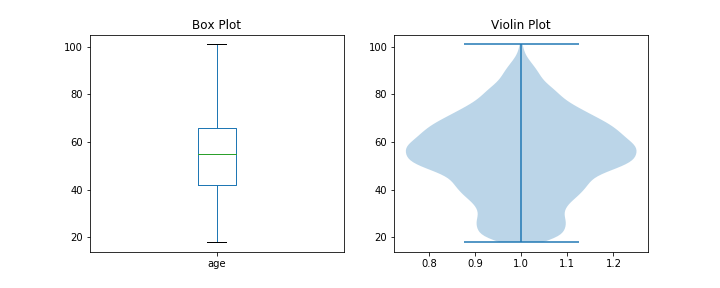

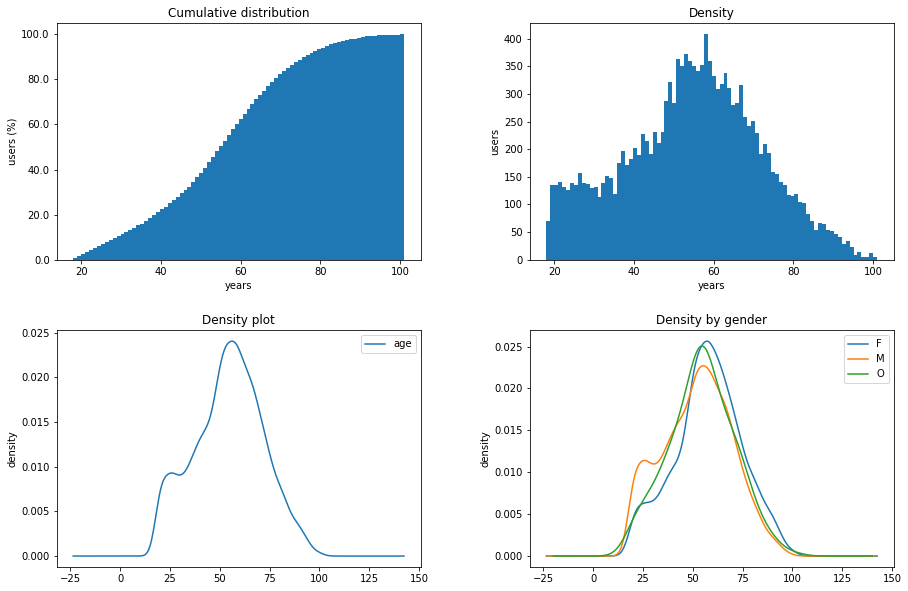

In [9]:
## Select registers with valid age
age_df = pd.DataFrame(profile_df.age[~age_missing])

## Generate the registers' description
description_pdstyle = \
    pd.DataFrame(age_df.describe()).style \
    .set_caption('Ages description') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

## Generate box and violin plots
fig1 = Figure(figsize=(10,4))
axs = fig1.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].set_title('Box Plot')
age_df.plot.box(ax=axs[0])
axs[1].violinplot(age_df.values)
axs[1].set_title('Violin Plot')

## Generate histograms
bins = 84
fig2, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.flatten()

# Cumulative distribution
age_df.hist(bins=bins, ax=axs[0], cumulative=True, density=True)
axs[0].set_title('Cumulative distribution')
axs[0].set_ylabel('users (%)')
axs[0].set_yticklabels((axs[0].get_yticks()*100).round(0))
axs[0].set_xscale('linear')
axs[0].set_xlabel('years')
axs[0].grid(False)

# Histogram
age_df.hist(bins=bins, ax=axs[1])
axs[1].set_title('Density')
axs[1].set_ylabel('users')
axs[1].set_xscale('linear')
axs[1].set_xlabel('years')
axs[1].grid(False)

# density
age_df.plot.density(ax=axs[2])
axs[2].legend()
axs[2].set_title('Density plot')
axs[2].set_ylabel('density')
axs[2].grid(False)

age_gender_df = profile_df[~age_missing].groupby('gender').age
age_gender_df.plot.density(ax=axs[3])
axs[3].set_title('Density by gender')
axs[3].set_ylabel('density')
axs[3].legend()
axs[3].grid(False)


## Display the information generated above
display_html('<center>' \
              + description_pdstyle._repr_html_() \
              + convert_fig_to_html(fig1) \
              + '</center>',
             raw=True)
plt.show()

Analyzing the graphs above, we can see that although the age is normally distributed among the population, there is a local peak around the interval 20 ~ 25 for both male and female genders. Apparently, this deviation is not a problem to be handled beforehand. However, this is a point to be taken into consideration if networks have difficulty to converge. Hence, simply standardization for this feature seems to be good enough, as shown in the graphs below.

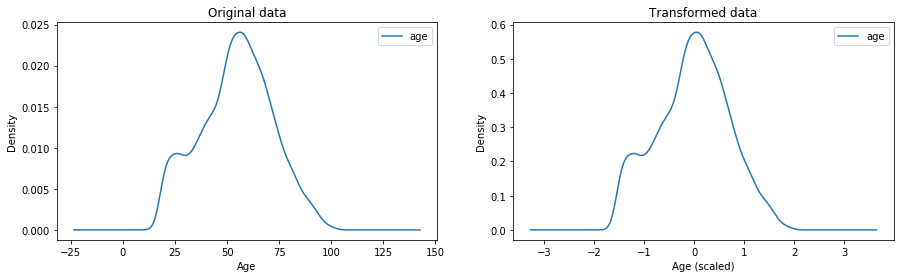

In [10]:
fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2)

age_df.plot.density(ax=axs[0])
axs[0].set_title('Original data')
axs[0].set_xlabel('Age')

data_transformed = robust_scale(age_df)
age_df = pd.DataFrame(data_transformed, columns=age_df.columns, index=age_df.index)

age_df.plot.density(ax=axs[1])
axs[1].set_title('Transformed data')
axs[1].set_xlabel('Age (scaled)')

plt.show()

### Explore income

,income
count,14825.00
mean,65404.99
std,21598.30
min,30000.00
25%,49000.00
50%,64000.00
75%,80000.00
max,120000.00

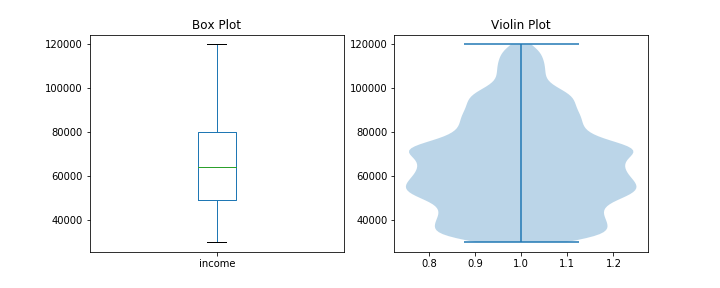

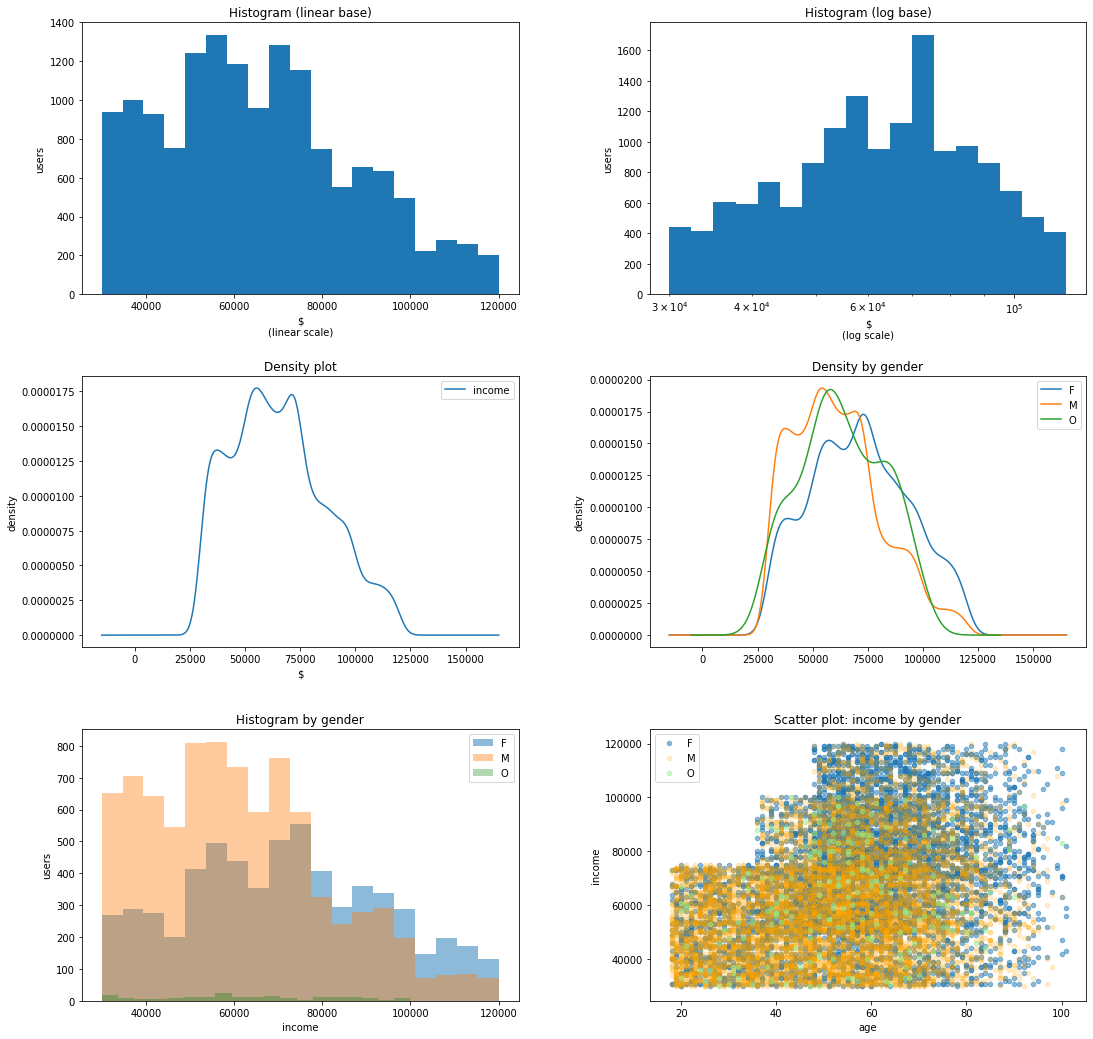

In [11]:
## Select registers with valid income
income_df = pd.DataFrame(profile_df.income[~income_isna])

## Generate the registers' description
description_pdstyle = \
    pd.DataFrame(income_df.describe()).style \
    .set_caption('Income description') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

## Generate box and violin plots
fig1 = Figure(figsize=(10,4))
axs = fig1.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].set_title('Box Plot')
income_df.plot.box(ax=axs[0])
axs[1].violinplot(income_df.values)
axs[1].set_title('Violin Plot')

## Generate histograms
bins = 19
logbins = np.logspace(np.log10(income_df.min().min()),
                      np.log10(income_df.max().max()),
                      num=bins)
fig2, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
axs = axs.flatten()

# linear scale
income_df.hist(bins=bins, ax=axs[0])
axs[0].set_title('Histogram (linear base)')
axs[0].set_ylabel('users')
axs[0].set_xscale('linear')
axs[0].set_xlabel('$\n(linear scale)')
axs[0].grid(False)

# log scale
income_df.hist(bins=logbins, ax=axs[1])
axs[1].set_title('Histogram (log base)')
axs[1].set_ylabel('users')
axs[1].set_xscale('log')
axs[1].set_xlabel('$\n(log scale)')
axs[1].grid(False)

# density
income_df.plot.density(ax=axs[2])
axs[2].set_title('Density plot')
axs[2].set_ylabel('density')
axs[2].set_xlabel('$')
axs[2].grid(False)

# Group income by gender
income_gender_df = profile_df[~income_isna].groupby('gender')
income_gender_df.income.plot.density(ax=axs[3])
axs[3].set_title('Density by gender')
axs[3].set_ylabel('density')
axs[3].legend()
axs[3].grid(False)

income_gender_df.get_group('F') \
    .income.hist(bins=bins, ax=axs[4], alpha=0.5, label='F')
income_gender_df.get_group('F') \
    .plot.scatter(x='age', y='income', ax=axs[5], alpha=0.5, label='F')

income_gender_df.get_group('M') \
    .income.hist(bins=bins, ax=axs[4], alpha=0.4, label='M')
income_gender_df.get_group('M') \
    .plot.scatter(x='age', y='income', c='orange',
                  ax=axs[5], alpha=0.2, label='M')

income_gender_df.get_group('O') \
    .income.hist(bins=bins, ax=axs[4], color='green', alpha=0.3, label='O')
income_gender_df.get_group('O') \
    .plot.scatter(x='age', y='income', c='lightgreen',
                  ax=axs[5], alpha=0.5, label='O')

axs[4].set_title('Histogram by gender')
axs[4].set_ylabel('users')
axs[4].set_xlabel('income')
axs[4].legend()
axs[4].grid(False)
axs[5].set_title('Scatter plot: income by gender')
axs[5].legend()
axs[5].grid(False)

# Display the information generated above
display_html('<center>' \
              + description_pdstyle._repr_html_() \
              + convert_fig_to_html(fig1) \
              + '</center>',
             raw=True)
plt.show()

These graphs show us that income is not a well distributed feature.  
The density plot is bimodal, including some other local peaks.  
Splitting the income by gender, we note that the number of men presenting income below $80,000 is considerably higher than women.  
The scatter plot shows us a strong correlation between some ranges of age and income, with well defined steps.

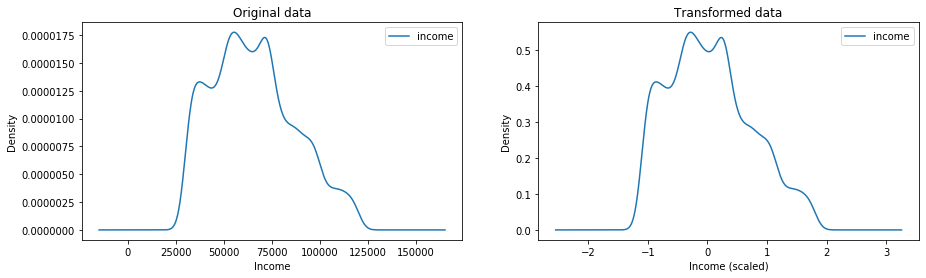

In [12]:
fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2)

income_df.plot.density(ax=axs[0])
axs[0].set_title('Original data')
axs[0].set_xlabel('Income')

data_transformed = robust_scale(income_df)
income_df = pd.DataFrame(data_transformed, columns=income_df.columns, index=income_df.index)

income_df.plot.density(ax=axs[1])
axs[1].set_title('Transformed data')
axs[1].set_xlabel('Income (scaled)')

plt.show()

### Explore membership

,became_member_on
count,17000.00
mean,20167034.23
std,11677.50
min,20130729.00
25%,20160526.00
50%,20170802.00
75%,20171230.00
max,20180726.00
,became_member_on
count,17000

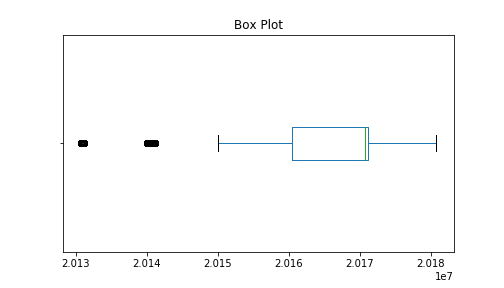

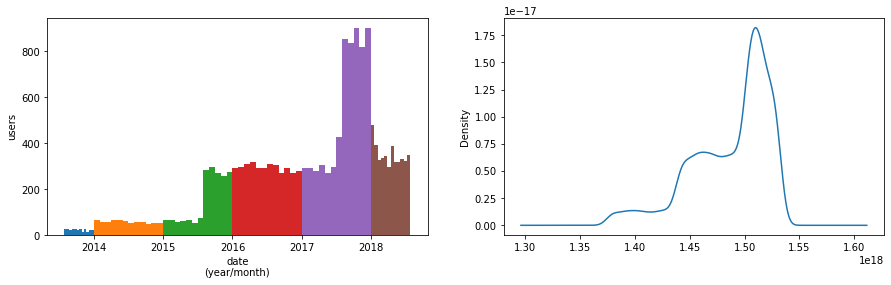

In [13]:
## Select registers
membership_df = profile_df.became_member_on

# Generate box plot
fig1 = Figure(figsize=(7,4))
ax = fig1.subplots()
ax.set_title('Box Plot')
membership_df.plot.box(ax=ax, vert=False)
ax.set_yticklabels('')

# Generate registers' description
member_desc_integers_pdstyle = \
    pd.DataFrame(membership_df.describe()).style \
    .set_caption('Membership description') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

## Convert data to datetime format
membership_df = pd.to_datetime(membership_df, format='%Y%m%d')

# Generate registers' description
member_desc_datetime_pdstyle = \
    pd.DataFrame(membership_df.describe()).style \
    .set_caption('Membership description') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

## Generate histograms
bins = 12
fig2, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

membership_df.groupby(membership_df.dt.year) \
    .hist(bins=bins, ax=axs[0])
axs[0].set_ylabel('users')
axs[0].set_xlabel('date\n(year/month)')
axs[0].grid(False)

membership_df.astype(np.long).plot.density(ax=axs[1])


## Display the information generated above
display_html('<center>' \
              + member_desc_integers_pdstyle._repr_html_() \
              + ' '
              + member_desc_datetime_pdstyle._repr_html_() \
              + convert_fig_to_html(fig1) \
              + '</center>',
             raw=True)
plt.show()

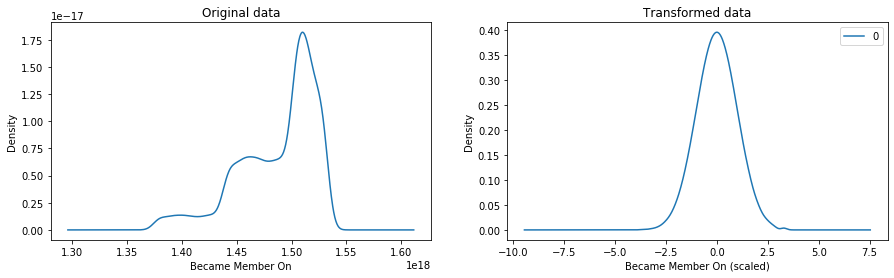

In [14]:
fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2)

membership_values = membership_df.astype(np.long)
membership_values.plot.density(ax=axs[0])
axs[0].set_title('Original data')
axs[0].set_xlabel('Became Member On')
 
membership_values = quantile_transform(membership_values.values.reshape(-1,1),
                                       output_distribution='normal',
                                       copy=True)
membership_df = pd.DataFrame(membership_values,
                             index=membership_df.index)

membership_df.plot.density(ax=axs[1])
axs[1].set_title('Transformed data')
axs[1].set_xlabel('Became Member On (scaled)')

plt.show()

# Transcript data set
Event log containing records for transactions, offers received, offers viewed, and offers completed.

## Overview

In [15]:
transcript_df = load_dataframe(transcript_data_path)
display(transcript_df.head())
display(pd.DataFrame(transcript_df.event.value_counts()).T \
        .assign(missing=transcript_df.event.isna().sum()) \
        .assign(total=transcript_df.count()) \
        .style.set_caption('Count events'))

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


,transaction,offer received,offer viewed,offer completed,missing,total
event,138953,76277,57725,33579,0,306534


## Exploration

### Initial transformation

The first step to understand this data set is splitting the value column, so that it is possible to analyze the relationship between events and results.

In [16]:
transcript_df = transcript_df.join(
    pd.DataFrame.from_records(transcript_df.pop('value')))
transcript_df.offer_id.update(transcript_df.pop('offer id'))

display(pd.DataFrame().append([
    transcript_df.query('event=="offer received"').head(),
    transcript_df.query('event=="offer viewed"').head(),
    transcript_df.query('event=="transaction"').head(),
    transcript_df.query('event=="offer completed"').head(),
    transcript_df.query('person=="78afa995795e4d85b5d9ceeca43f5fef"').head()]))

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN


In the representative dataset above, we notice that:
* *offer received* and *offer viewed* have an associated *offer id*
* *transaction* has an amount value that indicates how much the customer spent
* *offer completed* is associated to a reward value
* every event is informed with person and time
* distinct events can occur to the same person at the same time (see registers 47582 and 47583)

So that, we need to check if these statements are always true.

### Search for missing values

In [17]:
display(pd.DataFrame(
    {'offer received':
         transcript_df.query('event=="offer received"').notna().all(),
     'offer viewed':
         transcript_df.query('event=="offer viewed"').notna().all(),
     'transaction':
         transcript_df.query('event=="transaction"').notna().all(),
     'offer completed':
         transcript_df.query('event=="offer completed"').notna().all()
    }).T.style.set_caption('Is there missing information?'))

display(pd.DataFrame(
    {'offer received':
         transcript_df.query('event=="offer received"').isna().all(),
     'offer viewed':
         transcript_df.query('event=="offer viewed"').isna().all(),
     'transaction':
         transcript_df.query('event=="transaction"').isna().all(),
     'offer completed':
         transcript_df.query('event=="offer completed"').isna().all()
    }).T.style.set_caption('Is there event with extraneous information provided?'))

,person,event,time,amount,offer_id,reward
offer received,True,True,True,False,True,False
offer viewed,True,True,True,False,True,False
transaction,True,True,True,True,False,False
offer completed,True,True,True,False,True,True


,person,event,time,amount,offer_id,reward
offer received,False,False,False,True,False,True
offer viewed,False,False,False,True,False,True
transaction,False,False,False,False,True,True
offer completed,False,False,False,True,False,False


According to these verifications, there is no missing nor extraneous information in this dataset.  

Now, we neeed to verify if there is some inconsistent values in it.

### Explore events

,transaction,offer received,offer viewed,offer completed
event,138953,76277,57725,33579


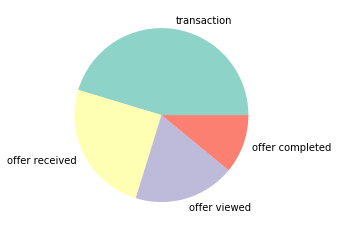

,reward,channels,difficulty,duration,offer_type,received,viewed,completed
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo,7658,6716,3688.0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,7593,7298,3331.0
3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational,7617,4144,NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,7677,4171,4354.0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,7668,2663,3420.0
2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount,7646,7337,5156.0
fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,7597,7327,5317.0
5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational,7618,6687,NaN
f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,7571,7264,4296.0


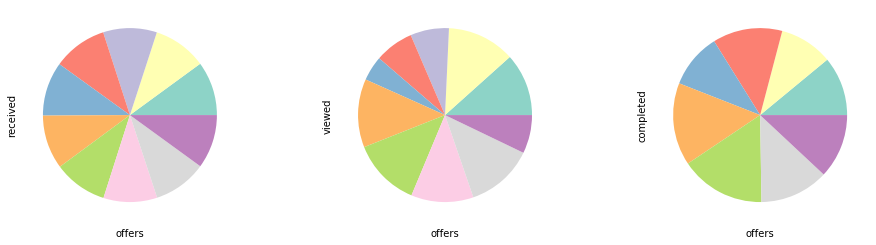

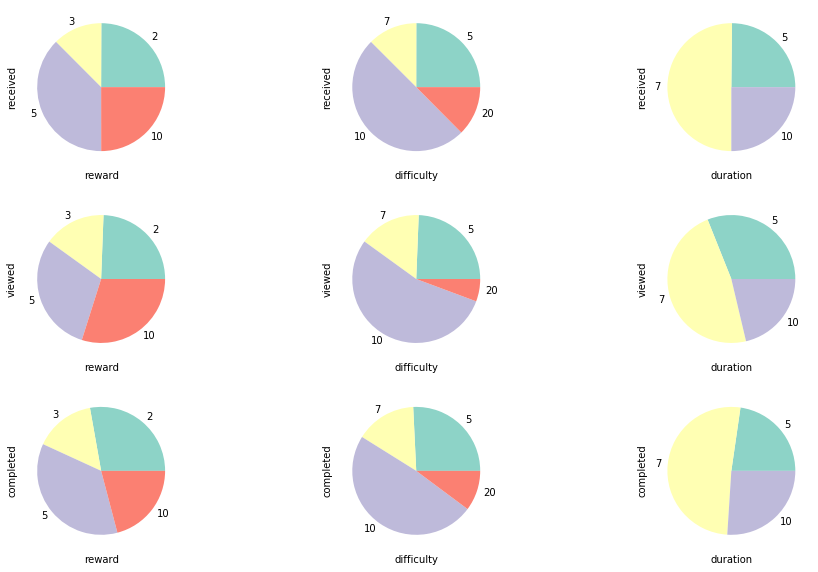

In [18]:
cmap = plt.get_cmap("Set3")
colors = cmap(range(10))

## Plot the number of events that occurred.
display(pd.DataFrame(transcript_df.event.value_counts()).T)
ax = transcript_df.event.value_counts().plot.pie(colors=colors)
ax.set_ylabel('')
plt.show()

## Count offers received, viewed, and completed
offer_event = load_dataframe(portfolio_data_path).set_index('id')
offer_event = offer_event.assign(
    received=pd.DataFrame(
        transcript_df.query('event == "offer received"')
        .offer_id.value_counts()))
offer_event = offer_event.assign(
    viewed=pd.DataFrame(
        transcript_df.query('event == "offer viewed"')
        .offer_id.value_counts()))
offer_event = offer_event.assign(
    completed=pd.DataFrame(
        transcript_df.query('event == "offer completed"')
        .offer_id.value_counts()))
display(offer_event)

# Plot
fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=3)
offer_event.received.plot.pie(ax=axs[0], labels=None, colors=colors)
offer_event.viewed.plot.pie(ax=axs[1], labels=None, colors=colors)
offer_event.completed.plot.pie(ax=axs[2], labels=None, colors=colors)
axs[0].set_xlabel('offers')
axs[1].set_xlabel('offers')
axs[2].set_xlabel('offers')
plt.show()

## Group events by reward, difficulty, and duration
fig, axs = plt.subplots(figsize=(16,10), nrows=3, ncols=3)

offer_event = offer_event.query('offer_type != "informational"')
event_by_reward = offer_event.groupby('reward').sum()
event_by_reward.received.plot.pie(ax=axs[0][0], colors=colors)
event_by_reward.viewed.plot.pie(ax=axs[1][0], colors=colors)
event_by_reward.completed.plot.pie(ax=axs[2][0], colors=colors)
axs[0][0].set_xlabel('reward')
axs[1][0].set_xlabel('reward')
axs[2][0].set_xlabel('reward')

event_by_difficulty = offer_event.groupby('difficulty').sum()
event_by_difficulty.received.plot.pie(ax=axs[0][1], colors=colors)
event_by_difficulty.viewed.plot.pie(ax=axs[1][1], colors=colors)
event_by_difficulty.completed.plot.pie(ax=axs[2][1], colors=colors)
axs[0][1].set_xlabel('difficulty')
axs[1][1].set_xlabel('difficulty')
axs[2][1].set_xlabel('difficulty')

event_by_duration = offer_event.groupby('duration').sum()
event_by_duration.received.plot.pie(ax=axs[0][2], colors=colors)
event_by_duration.viewed.plot.pie(ax=axs[1][2], colors=colors)
event_by_duration.completed.plot.pie(ax=axs[2][2], colors=colors)
axs[0][2].set_xlabel('duration')
axs[1][2].set_xlabel('duration')
axs[2][2].set_xlabel('duration')
plt.show()

There is no anomaly detected in the data related to events.  
Besides that, we note a correlation between views and channels. Not surprisingly, the more channels used to deliver the offer, the better. Additionally, using social media seems to be the most effective channel.  
Furthermore, there is some correlation between offer completion and features reward, difficulty, and duration. However, it seems more related to the number of offers received.

### Explore Transaction

In [19]:
amount_desc = pd.DataFrame(transcript_df.amount.describe()).style \
    .set_caption('Total') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

transcript_by_person = transcript_df.groupby('person')
amount_count_desc = pd.DataFrame(transcript_by_person.amount.count().describe()).style \
    .set_caption('Count by person') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')
amount_count_sum = pd.DataFrame(transcript_by_person.amount.sum().describe()).style \
    .set_caption('Sum by person') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

display_html(
    '<center>' \
    + amount_desc._repr_html_() \
    + ' ' \
    + amount_count_desc._repr_html_() \
    + ' ' \
    + amount_count_sum._repr_html_() \
    + '</center>',
    raw=True)

,amount
count,138953.00
mean,12.78
std,30.25
min,0.05
25%,2.78
50%,8.89
75%,18.07
max,1062.28
,amount
count,17000.00


These description tables show us some interesting points.  
* There are customers who did not make one single purchase in the period
* There are anomalous values in the amount feature

#### No purchase

Customers who did not make a transaction in this period: 422


,event
count,422.00
mean,4.46
std,1.12
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,6.00
,event
count,412.00

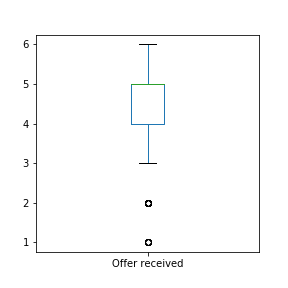
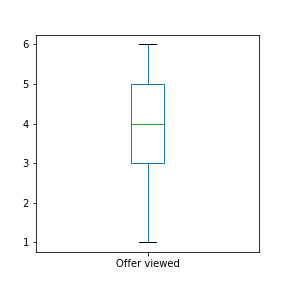

In [20]:
customers_no_transaction = transcript_by_person.count() \
    .query('amount == 0').index

print('Customers who did not make a transaction in this period:',
    customers_no_transaction.nunique())

## Offers sent to them
offer_received = transcript_df.query(
    'person in @customers_no_transaction ' \
    'and event == "offer received"') \
    .groupby('person') \
    .count()

boxplot_rec_fig = Figure(figsize=(4,4))
ax_rec = boxplot_rec_fig.subplots()

offer_received_desc = offer_received.event.describe()
offer_received_desc = pd.DataFrame(offer_received_desc) \
    .style.set_caption('Offers received') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')
offer_received.event.plot.box(ax=ax_rec)
ax_rec.set_xticklabels(labels=['Offer received'])


## Offers viewed by them
offer_viewed = transcript_df.query(
    'person in @customers_no_transaction ' \
    'and event == "offer viewed"') \
    .groupby('person') \
    .count()

boxplot_view_fig = Figure(figsize=(4,4))
ax_view = boxplot_view_fig.subplots()

offer_viewed_desc = offer_viewed.event.describe()
offer_viewed_desc = pd.DataFrame(offer_viewed_desc) \
    .style.set_caption('Offers viewed') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')
offer_viewed.event.plot.box(ax=ax_view)
ax_view.set_xticklabels(labels=['Offer viewed'])

display_html('<center>' \
              + offer_received_desc._repr_html_() \
              + convert_fig_to_html(boxplot_rec_fig) \
              + offer_viewed_desc._repr_html_() \
              + convert_fig_to_html(boxplot_view_fig) \
              + '</center>',
             raw=True)

There are 422 customers who did not make transactions in this period, even though they received and viewed offers.  
Admittedly, these customers may be analyzed in order to verify why they did not buy anything in the studied period. It is possible that they are opposed to marketing campaigns.  
Perhaps, they should be filtered out of the dataset. Anyways, this is a point to be aware and analyze while training and evaluating the networks.

#### Anomalous values

,count,mean,std,min,25%,50%,75%,max
amount,138953.0,12.78,30.25,0.05,2.78,8.89,18.07,1062.28


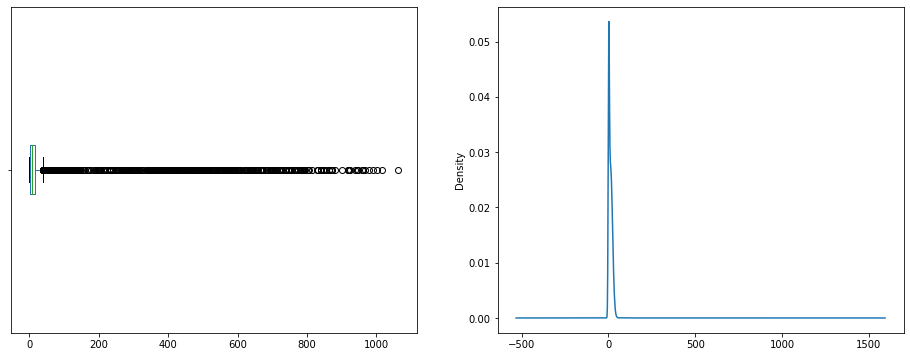

In [21]:
display(pd.DataFrame(transcript_df.amount.describe()).T)

fig, axs = plt.subplots(figsize=(16,6), nrows=1, ncols=2)

transcript_df.amount.plot.box(ax=axs[0], vert=False)
axs[0].set_yticklabels('')
transcript_df.amount.plot.density(ax=axs[1])
plt.show()

Anomalous values in transactions are so high that they deform completely the plots above.

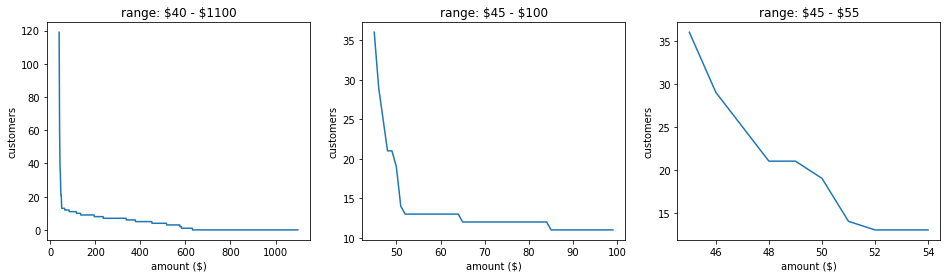

Number of customers with more than 1 transaction with a value >= $50,00: 19
Number of customers with transactions with a value >= $50,00: 687


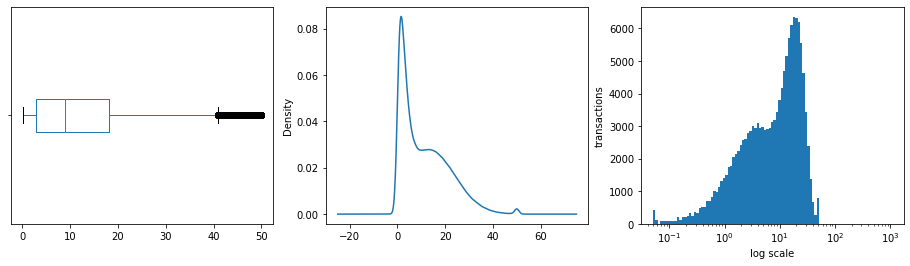

In [22]:
fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=3)

n_users = []
values = range(40,1100)
for v in values:
    n_users.append(transcript_df[transcript_df.amount > v] \
                   .person.duplicated().sum())
axs[0].plot(values, n_users)
axs[0].set_title('range: \$40 - \$1100')
axs[0].set_xlabel('amount ($)')
axs[0].set_ylabel('customers')

n_users = []
values = range(45,100)
for v in values:
    n_users.append(transcript_df[transcript_df.amount > v] \
                   .person.duplicated().sum())
axs[1].plot(values, n_users)
axs[1].set_title('range: \$45 - \$100')
axs[1].set_xlabel('amount ($)')
axs[1].set_ylabel('customers')

n_users = []
values = range(45,55)
for v in values:
    n_users.append(transcript_df[transcript_df.amount > v] \
                   .person.duplicated().sum())
axs[2].plot(values, n_users)
axs[2].set_title('range: \$45 - \$55')
axs[2].set_xlabel('amount ($)')
axs[2].set_ylabel('customers')

plt.show()


print('Number of customers with more than 1 transaction with a value >= $50,00:',
       transcript_df[transcript_df.amount >= 50].person.duplicated().sum())
print('Number of customers with transactions with a value >= $50,00:',
       transcript_df[transcript_df.amount >= 50].person.nunique())


fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=3)

transcript_df.amount.clip(lower=0.05, upper=50).plot.box(ax=axs[0], vert=False)
axs[0].set_yticklabels('')
transcript_df.amount.clip(lower=0.05, upper=50).plot.density(ax=axs[1])

bins = 100
logbins = np.logspace(np.log10(transcript_df.amount.min().min()),
                      np.log10(transcript_df.amount.max().max()),
                      num=bins)
transcript_df.amount.clip(0.05, 50).hist(bins=logbins, ax=axs[2])
axs[2].set_ylabel('transactions')
axs[2].set_xscale('log')
axs[2].set_xlabel('log scale')
axs[2].grid(False)

plt.show()

It is quite clear that one purchase with a value of \$1,062.28 in this dataset is an anomaly. However, it is especially tricky finding the value that correctly classifies outliers.  
I tried to define this value by finding the number of times one customer repeats transactions with a similar amount.   

The three graphs on the top show the number of customers who repeat a transaction with a value higher than a certain amount. Around the value 50, that number tends to stabilize.  
By setting the threshold to $50, there are 668 customers with transactions higher than this amount, and only 14 of them repeat a similar transaction.  

The three graphs on the bottom present transactions with value clipped to \$50.  